# KL between Bernoulli Posterior and DPP prior

This notebook demonstrates how to compute the KL divergence between a DPP prior and a Bernoulli posterior

In [1]:
#!pip install -U neptune-notebooks

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy
from genus.util_ml import Grid_DPP, compute_logp_bernoulli, compute_entropy_bernoulli
from genus.util_vis import show_batch

In [11]:
class simplified_model(torch.nn.Module):
    def __init__(self,
                 length_scale: float=5.0,
                 weight: float=0.2,
                 n_mc_samples: int=10):
        super().__init__()
        B, W, H = 8, 10, 10
        self.length_scale = length_scale
        self.weight = weight
        self.n_mc_samples = n_mc_samples
        self.grid_dpp = Grid_DPP(length_scale=length_scale,
                                 weight=weight,
                                 learnable_params=False)
        self.logit = torch.nn.Parameter(data=torch.randn((B,1,W,H), dtype=torch.float), requires_grad=True)
        
    def sample_dpp_prior(self):
        return self.grid_dpp.sample(size=self.logit.size())
        
    
    def forward(self):

        # This term can be compute analytically
        entropy_ber = compute_entropy_bernoulli(logit=self.logit).sum(dim=(-1, -2, -3)).mean()
  
        # Use the Bernoulli distribution at Temperature = 1 to evaluate the KL divergence
        prob_b1wh = torch.sigmoid(self.logit)
        prob_expanded_nb1wh = prob_b1wh.expand([self.n_mc_samples,-1,-1,-1,-1])  # keep: batch,ch,w,h
        c_mcsamples_nb1wh = (torch.rand_like(prob_expanded_nb1wh) < prob_expanded_nb1wh)
        logp_ber_nb = compute_logp_bernoulli(c=c_mcsamples_nb1wh.detach(), logit=self.logit).sum(dim=(-1, -2, -3))
        with torch.no_grad():
            logp_dpp_nb = self.grid_dpp.log_prob(value=c_mcsamples_nb1wh.squeeze(-3).detach())
            baseline_b = logp_dpp_nb.mean(dim=0) 
            d_nb = (logp_dpp_nb - baseline_b)
        reinforce_ber = (logp_ber_nb * d_nb.detach()).mean()
        logit_kl_av = - entropy_ber - reinforce_ber
        
        loss = logit_kl_av
        c_sample = (torch.rand_like(self.logit) < torch.sigmoid(self.logit))
        return loss, c_sample, reinforce_ber

In [16]:
import neptune.new as neptune

exp = neptune.init(project='cellarium/genus')
                                    
model = simplified_model(length_scale=5.0, 
                         weight=0.2, 
                         n_mc_samples=10)
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 0.001}])

https://ui.neptune.ai/cellarium/genus/e/GEN-158


### Log info about the simulation

In [17]:
exp["config/length_scale"].log(model.length_scale)
exp["config/weight"].log(model.weight)
exp["config/n_mc_samples"].log(model.n_mc_samples)

### Log info about the prior

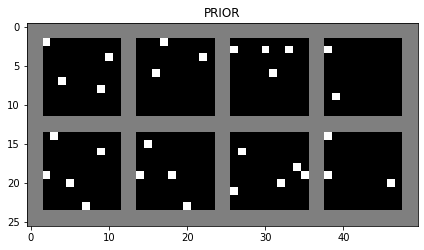

In [18]:
c_grid = model.sample_dpp_prior()
n_av = model.grid_dpp.n_mean
n_std = model.grid_dpp.n_stddev

exp["prior/n_cell_av"].log(n_av)
exp["prior/n_cell_p1sigma"].log(n_av+n_std)
exp["prior/n_cell_m1sigma"].log(n_av-n_std)

show_batch(model.logit, pad_value=1.0, n_padding=2, normalize_range=(-3.0, 3.0), 
               normalize=True, experiment=exp, neptune_name="prior/logit_raw", title="PRIOR")
show_batch(c_grid.float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="prior/c_grid", title="PRIOR")

In [21]:
for epoch in range(10000):
    loss, c_grid, delta = model.forward()
    
    optimizer.zero_grad()
    loss.backward()  # do back_prop and compute all the gradients
    optimizer.step()  # update the parameters    
    
    if epoch % 100 == 0:
        n_cell_b = c_grid.sum(dim=(-1,-2,-3)).float()
        n_cell_std, n_cell_av = torch.std_mean(n_cell_b)
        n_cell_p1sigma = (n_cell_av+n_cell_std).detach().item()
        n_cell_m1sigma = (n_cell_av-n_cell_std).detach().item()
        
        n_cell_min = n_cell_b.min().detach().item()
        n_cell_max = n_cell_b.max().detach().item()
        exp["posterior/n_cell_av"].log(n_cell_av)
        exp["posterior/n_cell_min"].log(n_cell_min)
        exp["posterior/n_cell_max"].log(n_cell_max)        
        exp["posterior/n_cell_p1sigma"].log(n_cell_p1sigma)
        exp["posterior/n_cell_m1sigma"].log(n_cell_m1sigma)

        logit_min = torch.min(model.logit).item()
        logit_mean = torch.mean(model.logit).item()
        logit_max = torch.max(model.logit).item()
        exp["posterior/logit_min"].log(logit_min)
        exp["posterior/logit_mean"].log(logit_mean)
        exp["posterior/logit_max"].log(logit_max)
        
        exp["delta"].log(delta.detach().item())
        
        show_batch(c_grid.float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="posterior/c_grid", 
                   title="epoch="+str(epoch))
        show_batch(model.logit, pad_value=1.0, n_padding=2, normalize_range=(-5.0, 5.0), 
               normalize=True, experiment=exp, neptune_name="posterior/logit_raw", title="epoch="+str(epoch))
        
        print(epoch, loss)

0 tensor(-69.7418, grad_fn=<SubBackward0>)
100 tensor(-79.7570, grad_fn=<SubBackward0>)
200 tensor(-67.4798, grad_fn=<SubBackward0>)
300 tensor(-77.9402, grad_fn=<SubBackward0>)
400 tensor(-55.4912, grad_fn=<SubBackward0>)
500 tensor(-54.4585, grad_fn=<SubBackward0>)
600 tensor(-63.3943, grad_fn=<SubBackward0>)
700 tensor(-43.3412, grad_fn=<SubBackward0>)
800 tensor(-65.5327, grad_fn=<SubBackward0>)
900 tensor(-63.0782, grad_fn=<SubBackward0>)
1000 tensor(-62.4086, grad_fn=<SubBackward0>)
1100 tensor(-48.8099, grad_fn=<SubBackward0>)
1200 tensor(-52.2643, grad_fn=<SubBackward0>)
1300 tensor(-65.8219, grad_fn=<SubBackward0>)
1400 tensor(-80.7400, grad_fn=<SubBackward0>)
1500 tensor(-65.6604, grad_fn=<SubBackward0>)
1600 tensor(-58.4161, grad_fn=<SubBackward0>)
1700 tensor(-56.2502, grad_fn=<SubBackward0>)
1800 tensor(-59.8957, grad_fn=<SubBackward0>)
1900 tensor(-74.6978, grad_fn=<SubBackward0>)
2000 tensor(-49.9101, grad_fn=<SubBackward0>)
2100 tensor(-74.2388, grad_fn=<SubBackward0>)


# Analyze final value

In [33]:
logit_final = model.logit.clone()

print("logit_min", logit_final.min().cpu().detach().item())
print("logit_mean", logit_final.mean().cpu().detach().item())
print("logit_max", logit_final.max().cpu().detach().item())

logit_min -3.9467544555664062
logit_mean -3.2642464637756348
logit_max -2.4515037536621094


In [35]:
expected_final_prob = n_av / torch.numel(logit_final[-2:])
expected_final_logit = torch.log(expected_final_prob) - torch.log(1-expected_final_prob)

In [36]:
print(expected_final_logit)

tensor(-3.9604)


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/neptune/new/internal/backends/utils.py", line 51, in wrapper
    return func(*args, **kwargs)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/neptune/new/internal/backends/hosted_neptune_backend.py", line 229, in ping_run
    self.leaderboard_client.api.ping(experimentId=str(run_uuid)).response().result
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/six.py", line 703, in reraise
    raise value
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/bravado

Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stderr : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stderr : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stderr : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stderr : Text longer than 1000 characters was truncated
Unexpected error occurred. Killing Neptune asynchronous thread. All data is safe on disk.
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/urllib3/response.py", line 697, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: 

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/urllib3/response.py", line 697, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/urllib3/response.py", line 764, in read_chunked
    self._update_chunk_length()
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/urllib3/response.py", line 701, in _update_chunk_length
    raise InvalidChunkLength(self, line)
urllib3.exceptions.InvalidChunkLength: InvalidChunkLength(got length b'', 0 bytes read)

During handling of the above exception, another exception occurred:
